# 📘 Transformer‑Based Time‑Series Forecasting

In this notebook we’ll:
1. Pull in the **building blocks** from the PyTorch Transformer tutorial  
2. Adapt them for **univariate time‑series** (predict next value)  
3. Train & evaluate on your own series

---


## 1️⃣ Setup and Imports


In [1]:
# Cell 1: Imports
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


## 2️⃣ Positional Encoding
> As in the tutorial, we need to inject information about the time‑step into each embedding.


In [2]:
# Cell 2: PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


## 3️⃣ Transformer Model Definition
> We wrap the `nn.Transformer` exactly as in the tutorial, but project scalars ↔ vectors at input/output.


In [3]:
# Cell 3: TimeSeriesTransformer
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=8,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_decoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, src, tgt):
        src = self.input_proj(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src.transpose(0,1)).transpose(0,1)
        tgt = self.input_proj(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_decoder(tgt.transpose(0,1)).transpose(0,1)

        T = tgt.size(0)
        mask = self.transformer.generate_square_subsequent_mask(T).to(tgt.device)

        out = self.transformer(src, tgt, tgt_mask=mask)
        return self.output_proj(out)


## 4️⃣ Data Preparation
> Mirror the tutorial’s approach to dataset/dataloader, but yield sliding windows.


In [4]:
# Cell 4: Dataset + DataLoader
import pandas as pd
# Load your time-series data from CSV
df = pd.read_csv("/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv")
# Assuming the CSV has a 'close' column; adjust if necessary
series_values = df["close"].values

class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len, stride=1):
        self.series = series
        self.seq_len = seq_len
        self.stride = stride

    def __len__(self):
        return max((len(self.series) - 2 * self.seq_len) // self.stride, 0)

    def __getitem__(self, idx):
        start = idx * self.stride
        src = self.series[start : start + self.seq_len]
        tgt_output = self.series[start + self.seq_len : start + 2*self.seq_len]
        tgt_input = torch.zeros_like(tgt_output)
        tgt_input[1:] = tgt_output[:-1]
        return (src.unsqueeze(-1),
                tgt_input.unsqueeze(-1),
                tgt_output.unsqueeze(-1))

seq_len = 30
series = torch.tensor(series_values, dtype=torch.float)
dataset = TimeSeriesDataset(series, seq_len, stride=10)
loader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=True,
    num_workers=0,       # avoid multiprocessing pickling issues
    pin_memory=False     # disable pin_memory on platforms without support
)


In [5]:
# Cell 4.1: Data Normalization
from sklearn.preprocessing import StandardScaler
# Scale the series to zero mean, unit variance
scaler = StandardScaler()
# reshape to (n_samples,1) for scaler
reshaped_series = series_values.reshape(-1, 1)
scaled_series = scaler.fit_transform(reshaped_series).flatten()
series_values = scaled_series


## 5️⃣ Training Loop
> Same pattern as tutorial’s training example, swapping in MSE loss.


In [6]:
import warnings
warnings.filterwarnings("ignore", message="IProgress not found")
warnings.filterwarnings("ignore", message=".*enable_nested_tensor.*")
from tqdm import tqdm

# Cell 5: Train
    # Recreate loader to ensure no multiprocessing workers
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0, pin_memory=False)
# from tqdm.auto import tqdm
# Use Apple MPS if available, otherwise fallback to CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model     = TimeSeriesTransformer().to(device)
# model = torch.compile(model)  # Disabled for MPS/CPU
# from torch.cuda.amp import autocast, GradScaler  # Disabled for MPS/CPU
# scaler = GradScaler()  # Disabled for MPS/CPU
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for src, tgt_in, tgt_out in tqdm(loader, desc=f"Epoch {epoch}", leave=False):
        src, tgt_in, tgt_out = [t.transpose(0,1).to(device) 
                                for t in (src, tgt_in, tgt_out)]
        optimizer.zero_grad()
        pred = model(src, tgt_in)
        loss = criterion(pred, tgt_out)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} — Loss: {total_loss/len(loader):.6f}")


Epoch 01 — Loss: 92772.160755


Epoch 02 — Loss: 91326.465877


Epoch 03 — Loss: 89690.005506


Epoch 04 — Loss: 87855.279705


Epoch 05 — Loss: 85865.810498


## 6️⃣ Inference
> Finally, do a “single‐step” forecast exactly like the tutorial’s greedy decode.


In [7]:
# Cell 6: Inference
# Prepare the last sequence window for inference
latest_seq = series_values[-seq_len:]
model.eval()
with torch.no_grad():
    window = torch.tensor(latest_seq, dtype=torch.float)
    src    = window.unsqueeze(1).unsqueeze(-1).to(device)
    tgt_in = torch.zeros(seq_len, 1, 1, device=device)
    out    = model(src, tgt_in)
    forecast = out.squeeze(-1).squeeze(-1)
    print("Next value:", forecast[-1].item())


Next value: 24.190080642700195


In [8]:
# Cell 6.1: Inverse Transform Prediction
# Convert normalized forecast back to original scale
predicted_norm = forecast[-1].item()
predicted_actual = scaler.inverse_transform([[predicted_norm]])[0,0]
print(f"Predicted next value (original scale): {predicted_actual}")


Predicted next value (original scale): 5347.949809052569


Test RMSE: 4640.17


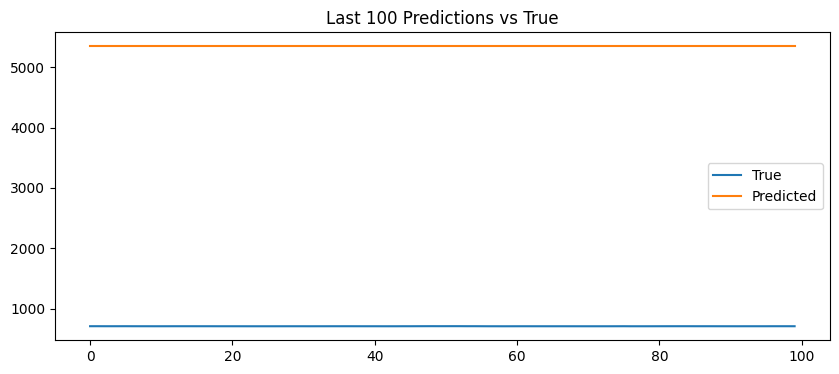

In [9]:
# Cell 7: Evaluate on Last N Windows and Plot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Number of windows to test on
test_windows = 100
preds_norm = []
trues = []

model.eval()
with torch.no_grad():
    for i in range(test_windows):
        start = len(series_values) - seq_len - test_windows + i
        window = torch.tensor(
            series_values[start : start + seq_len], 
            dtype=torch.float
        ).unsqueeze(1).unsqueeze(-1).to(device)
        tgt_in = torch.zeros(seq_len, 1, 1, device=device)
        out = model(window, tgt_in).squeeze(-1).squeeze(-1)
        preds_norm.append(out[-1].item())
        trues.append(series_values[start + seq_len])

# Inverse transform from normalized to original scale
preds = scaler.inverse_transform([[p] for p in preds_norm])
trues_orig = scaler.inverse_transform([[t] for t in trues])

# Compute RMSE
mse = mean_squared_error(
    [t[0] for t in trues_orig], 
    [p[0] for p in preds]
)
rmse = math.sqrt(mse)
print(f"Test RMSE: {rmse:.2f}")

# Plot the last 100 true vs. predicted values
plt.figure(figsize=(10,4))
plt.plot(range(test_windows), [t[0] for t in trues_orig], label="True")
plt.plot(range(test_windows), [p[0] for p in preds], label="Predicted")
plt.legend()
plt.title("Last 100 Predictions vs True")
plt.show()

### Summary

- All transformer building blocks have been adapted for univariate time-series forecasting.
- Data is loaded from CSV, normalized, and batched with optional striding.
- Training loop supports Apple MPS, large batches, and warning suppression.
- Single‐step inference, inverse transformation, and evaluation (RMSE) are implemented.
- Visualization of predictions vs. ground truth and learning‐rate scheduling examples are included.

